In [1]:
# Импорт библиотек
import os
import time
import KU_TU
import GTU
import SP
import mat_properties as prop
import numpy as n
import pandas as pd
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel(
    "streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)

# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

############################################################
# Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc()
electric.at["GTU", "N"] = Gas_turbine_res["N"]
electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.at["GTU-KU", "P"] = 0.1
gas_streams.at['GTU-KU', 'H'] = gas0.p_t(
    gas_streams.at['GTU-KU', 'P'], gas_streams.at['GTU-KU', 'T'])['h']
Gas_turbine_composition = pd.read_excel(
    "input.xlsx", sheet_name="Gas_composition0", index_col=0)

# Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.at["GTU-PEVD",
               "N2":"Ar"] = Gas_turbine_composition.loc["Fraction", "N2":"Ar"]

############################################################
#Теплосеть
gas_streams.at["AIR", "T":"P"] = [GTU_input.loc["tair",1],0.1]
water_streams.at["AIR", "T":"P"] = [GTU_input.loc["tair",1],0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWIN-TURB", "T"] = SP.Tset(Tnv)[1]
water_streams.at["SP2-WOUT", "T"] = SP.Tset(Tnv)[0]
# print(water_streams)
############################################################

# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Основные константы
Calcmethod = "hybr"
KPD_PN = 0.8074
KPD_KN = 0.7
KPD_to = 0.99
KPD_SP = 0.99

Calctolerance = 10**-2
Teplo = 1
Maxiterations_KU_TU = 20
Maxiterations_cotel = 5
Maxiterations_turbine = 10

#Claas KU+TU
KU_and_TU=KU_TU.ku_tu(gas0, gas1,  water, gas_streams0, gas_streams, water_streams0, water_streams, heaters, electric,Calcmethod, KPD_SP, KPD_KN, KPD_to, KPD_PN)

start_time = time.time()

KU_and_TU.calculate(Teplo,Calctolerance,Maxiterations_KU_TU,Maxiterations_cotel,Maxiterations_turbine)

print("Степень сухости пара в ЭВД: ", water.p_h(
    water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],)
print("Степень сухости пара в ГПК: ", water.p_h(
    water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],)

print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")

Достигнуто максимальное количество итераций контура высокого давления
Fin котел-утилизатора:--- 22.74 сек. ---
dQ/Qsumm 0.028186143830786787
Fin турбоустановка:--- 0.1 сек. ---
Fin котел-утилизатора:--- 5.48 сек. ---
dQ/Qsumm -0.020255568221330598
Fin турбоустановка:--- 0.1 сек. ---
Fin котел-утилизатора:--- 2.72 сек. ---
dQ/Qsumm -0.0058895305722337895
Fin турбоустановка:--- 0.06 сек. ---
Максимальная погрешность определения расхода в КУ+ПТУ 0.035375323173625885
Pnd_it [0.47491]
Pvd_it [5.75101]
Время 1 итерации расчета КУ+ТУ:--- %s сек. --- 31.2
Fin котел-утилизатора:--- 8.83 сек. ---
dQ/Qsumm 0.0807721351666894
Достигнуто максимальное количество итераций давления верхнего отбора
Недостаточное количество итераций
Fin турбоустановка:--- 2.48 сек. ---
Fin котел-утилизатора:--- 7.47 сек. ---
dQ/Qsumm 0.040991532567718245
Fin турбоустановка:--- 1.3 сек. ---
Fin котел-утилизатора:--- 2.79 сек. ---
dQ/Qsumm -0.005813155050382308
Fin турбоустановка:--- 0.2 сек. ---
Fin котел-утилизатора:---

In [2]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,15.000000,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,525.479236,0.1,939.522951,349.678936,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,525.479236,0.1,939.522951,349.678936,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,454.073569,0.1,858.224793,349.678936,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,280.956556,0.1,666.696042,349.678936,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,226.083255,0.1,607.546989,349.678936,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,223.011664,0.1,604.255923,349.678936,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,157.623375,0.1,534.643660,349.678936,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,92.755385,0.1,466.305125,349.678936,0.7803,0.1237,0.0301,0.0594,0.0065


In [3]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,508.231766,5.696025,3446.079588,42.594724,NaN,NaN
IVD-PEVD,274.853899,5.933062,2785.311621,42.594724,NaN,NaN
EVD-IVD,274.853899,5.933062,1228.658001,42.594724,NaN,NaN
PEN-EVD,175.984297,5.933062,747.991615,42.594724,NaN,NaN
BND-PEN,148.050076,0.451792,623.770811,42.594724,NaN,NaN
PPND-DROSND,194.394145,0.447224,2846.633065,11.053007,NaN,NaN
IND-PPND,148.050076,0.451792,2743.564580,11.053007,NaN,NaN
GPK-IND,145.151795,0.451792,611.313113,53.647731,NaN,NaN
GPK-REC,145.151795,0.451792,611.313113,65.757493,NaN,NaN


In [4]:
Errors_water = abs(water_streams - water_streams0)/water_streams0*100
Errors_gas = abs(gas_streams-gas_streams0)/gas_streams0*100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,NaN,NaN
BND-PEN,32.815893,10.390061,35.124632,NaN,10.130176,NaN
DOOTB1,57.314715,4.693210,80.907851,5.460134,NaN,NaN
DOOTB2,31.361655,2.567548,65.312888,4.190407,26.845072,NaN
DROSND-TURBND,25.115130,0.863469,37.847478,2.307014,8.156669,NaN
DROSVD-TURBVD,32.815893,0.688209,32.247854,NaN,0.429586,NaN
ENDOFVD,32.815893,0.088648,37.161403,NaN,2.026511,NaN
EVD-IVD,32.815893,8.168497,32.162563,NaN,8.014090,NaN
GPK-BYPASS,NaN,NaN,NaN,NaN,NaN,NaN
GPK-IND,31.361655,12.103717,35.124632,NaN,11.815434,NaN


In [5]:
gas_streams0

,T,P,H,G,N2,O2,CO2,H2O,Ar
GTU-KU,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,874.031830,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,697.417326,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,618.078812,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,614.965387,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,553.594555,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,481.155410,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
electric

,Ni,N,KPDm,KPD
PEN,5.291151,6.380520,0.829266,0.047958
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,75.375300,NaN,27.500847
DK,NaN,6.109817,NaN,NaN
Turbine,41.028562,NaN,NaN,NaN
Tots1,25.525870,NaN,NaN,0.848579
Tots2,10.293465,NaN,NaN,0.772706
Tots3,0.960028,NaN,NaN,0.733751
Tots4,4.249199,NaN,NaN,0.342536


In [7]:
heaters

,Qw,Qg,KPD
PEVD,28143.970668,28428.253200,0.99
IVD,66303.834317,66973.570017,0.99
EVD,20476.346134,20683.177913,0.99
PPND,1139.308021,1150.816183,0.99
IND,24098.522761,24341.942183,0.99
GPK,23657.580683,23896.546144,0.99
SP2,45.344287,NaN,0.99
SP1,49.202348,NaN,0.99
OD,4.087266,NaN,0.99


In [8]:
GTU_input

,1,2,3,4,5,6
tair,15.0,NaN,NaN,NaN,NaN,NaN
n,0.5,NaN,NaN,NaN,NaN,NaN
Pin,0.0,NaN,NaN,NaN,NaN,NaN
Pout,0.0,NaN,NaN,NaN,NaN,NaN


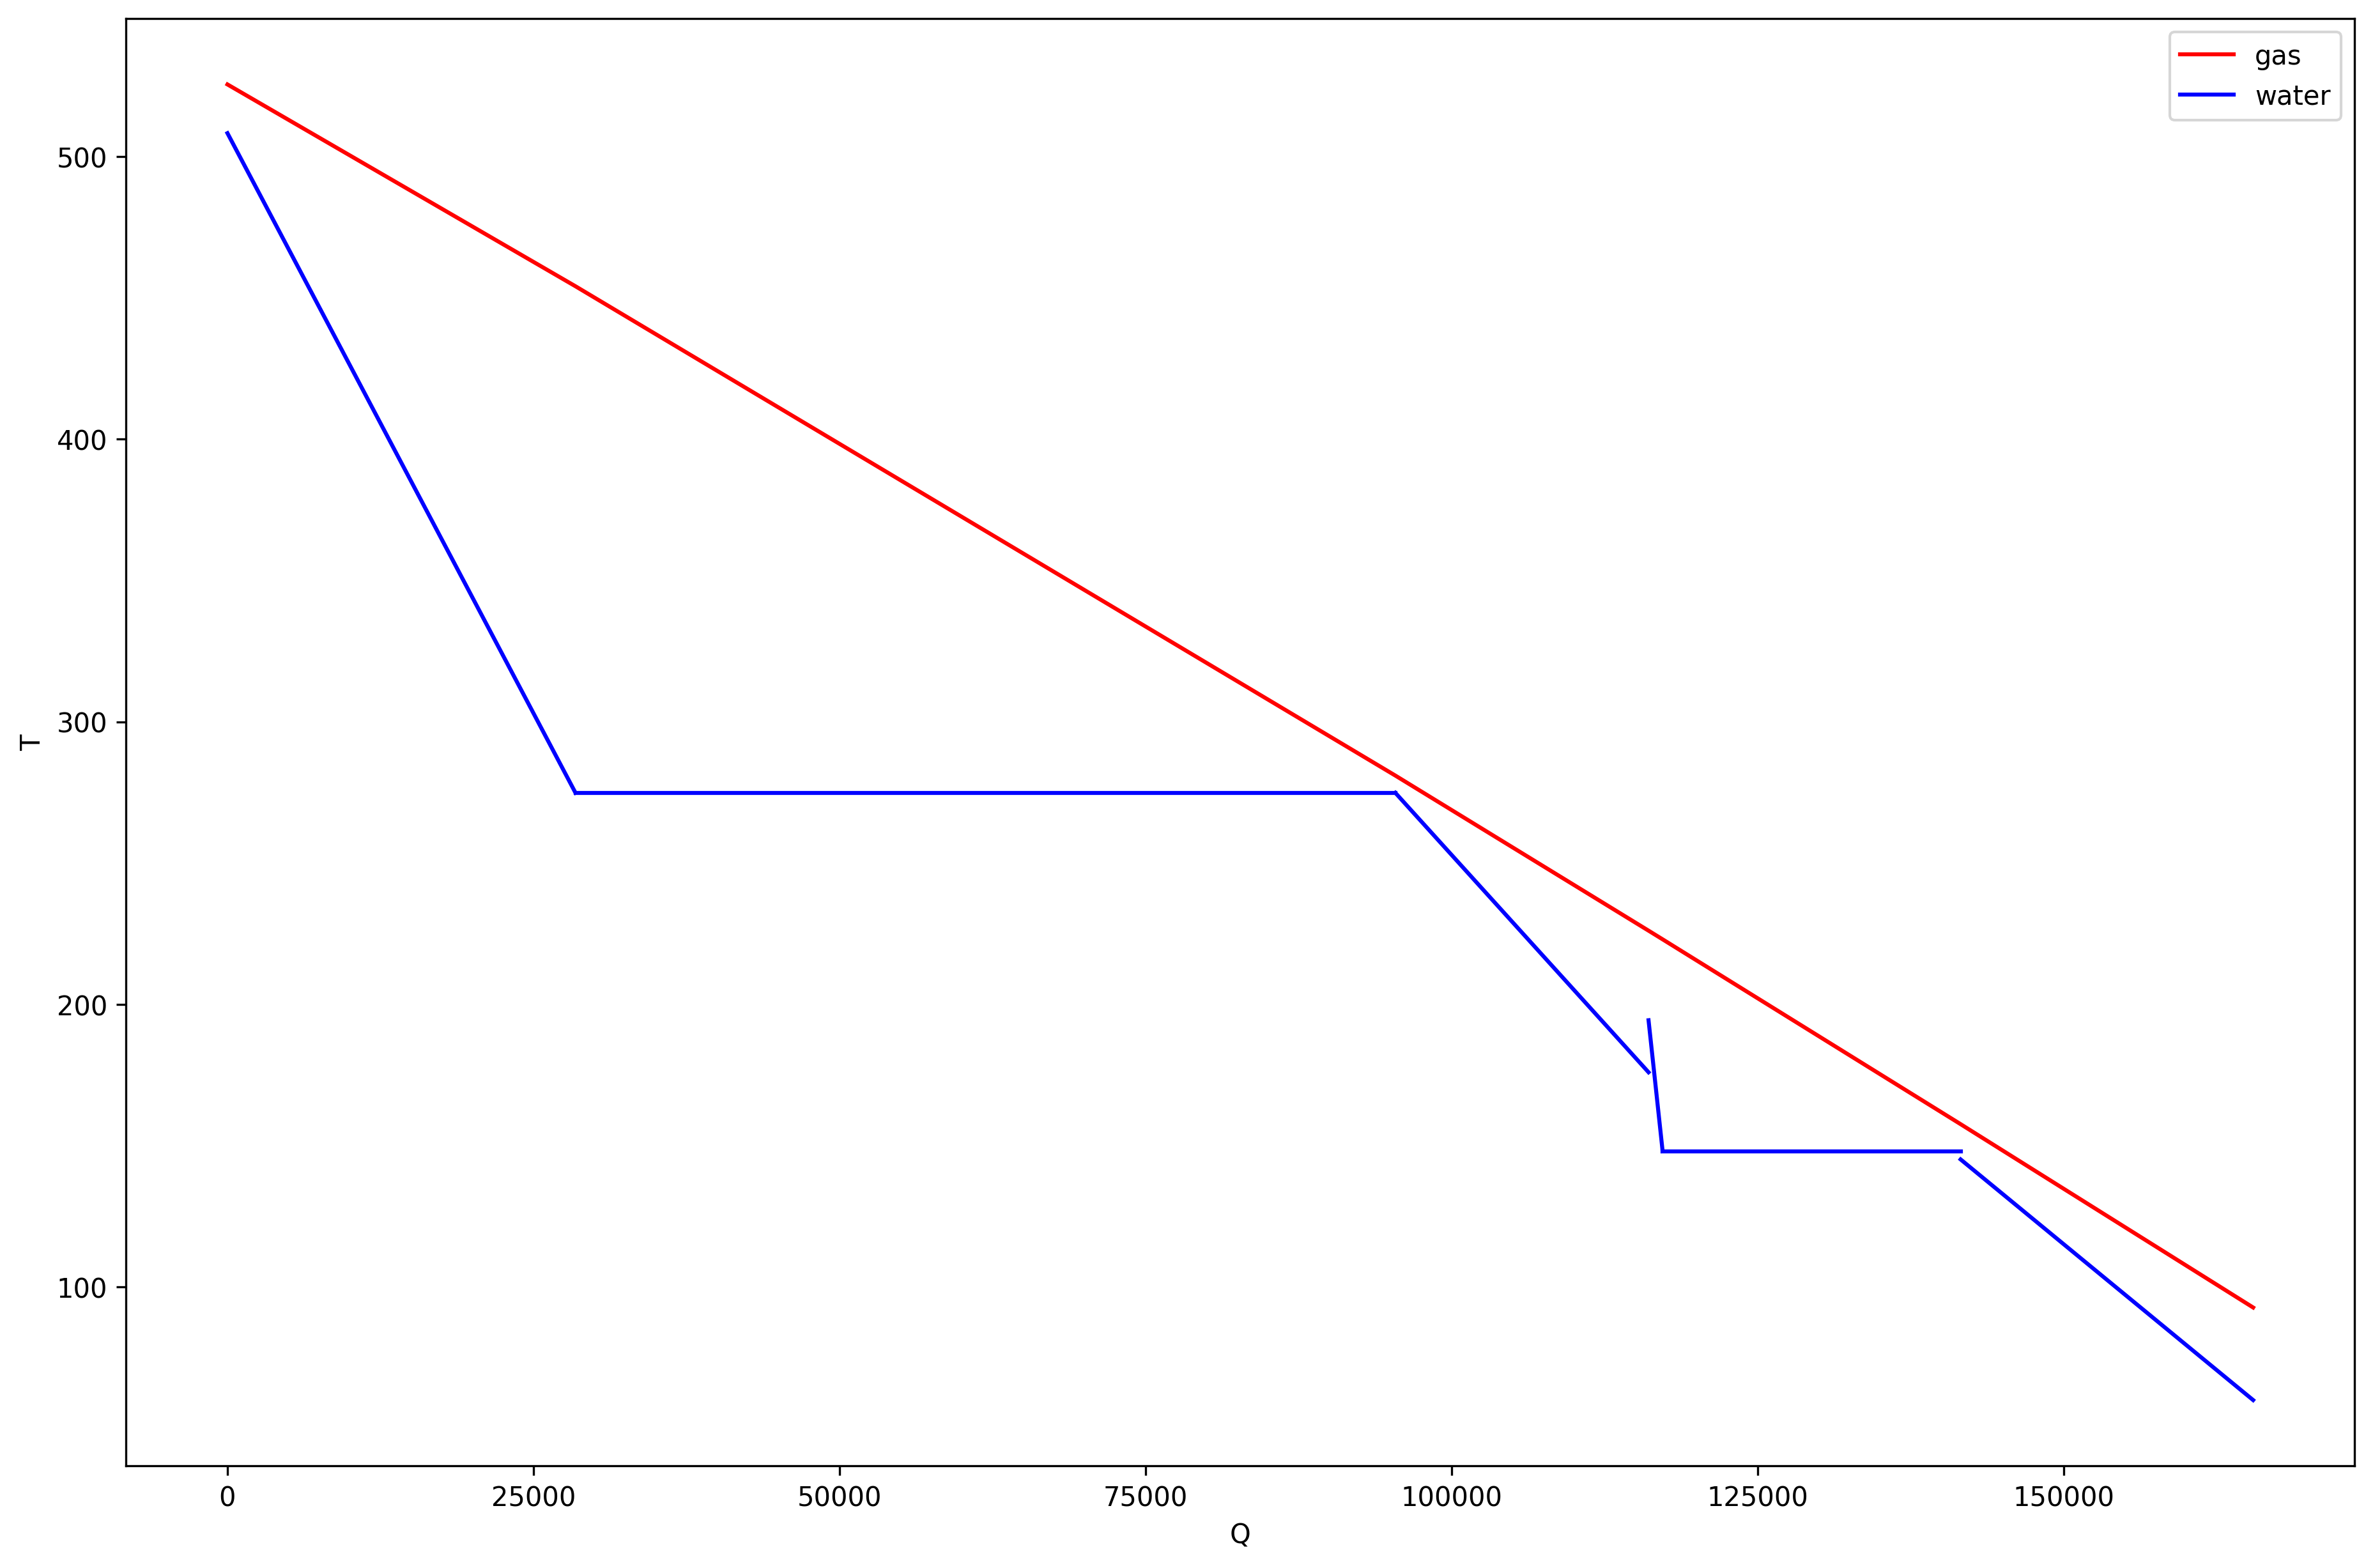

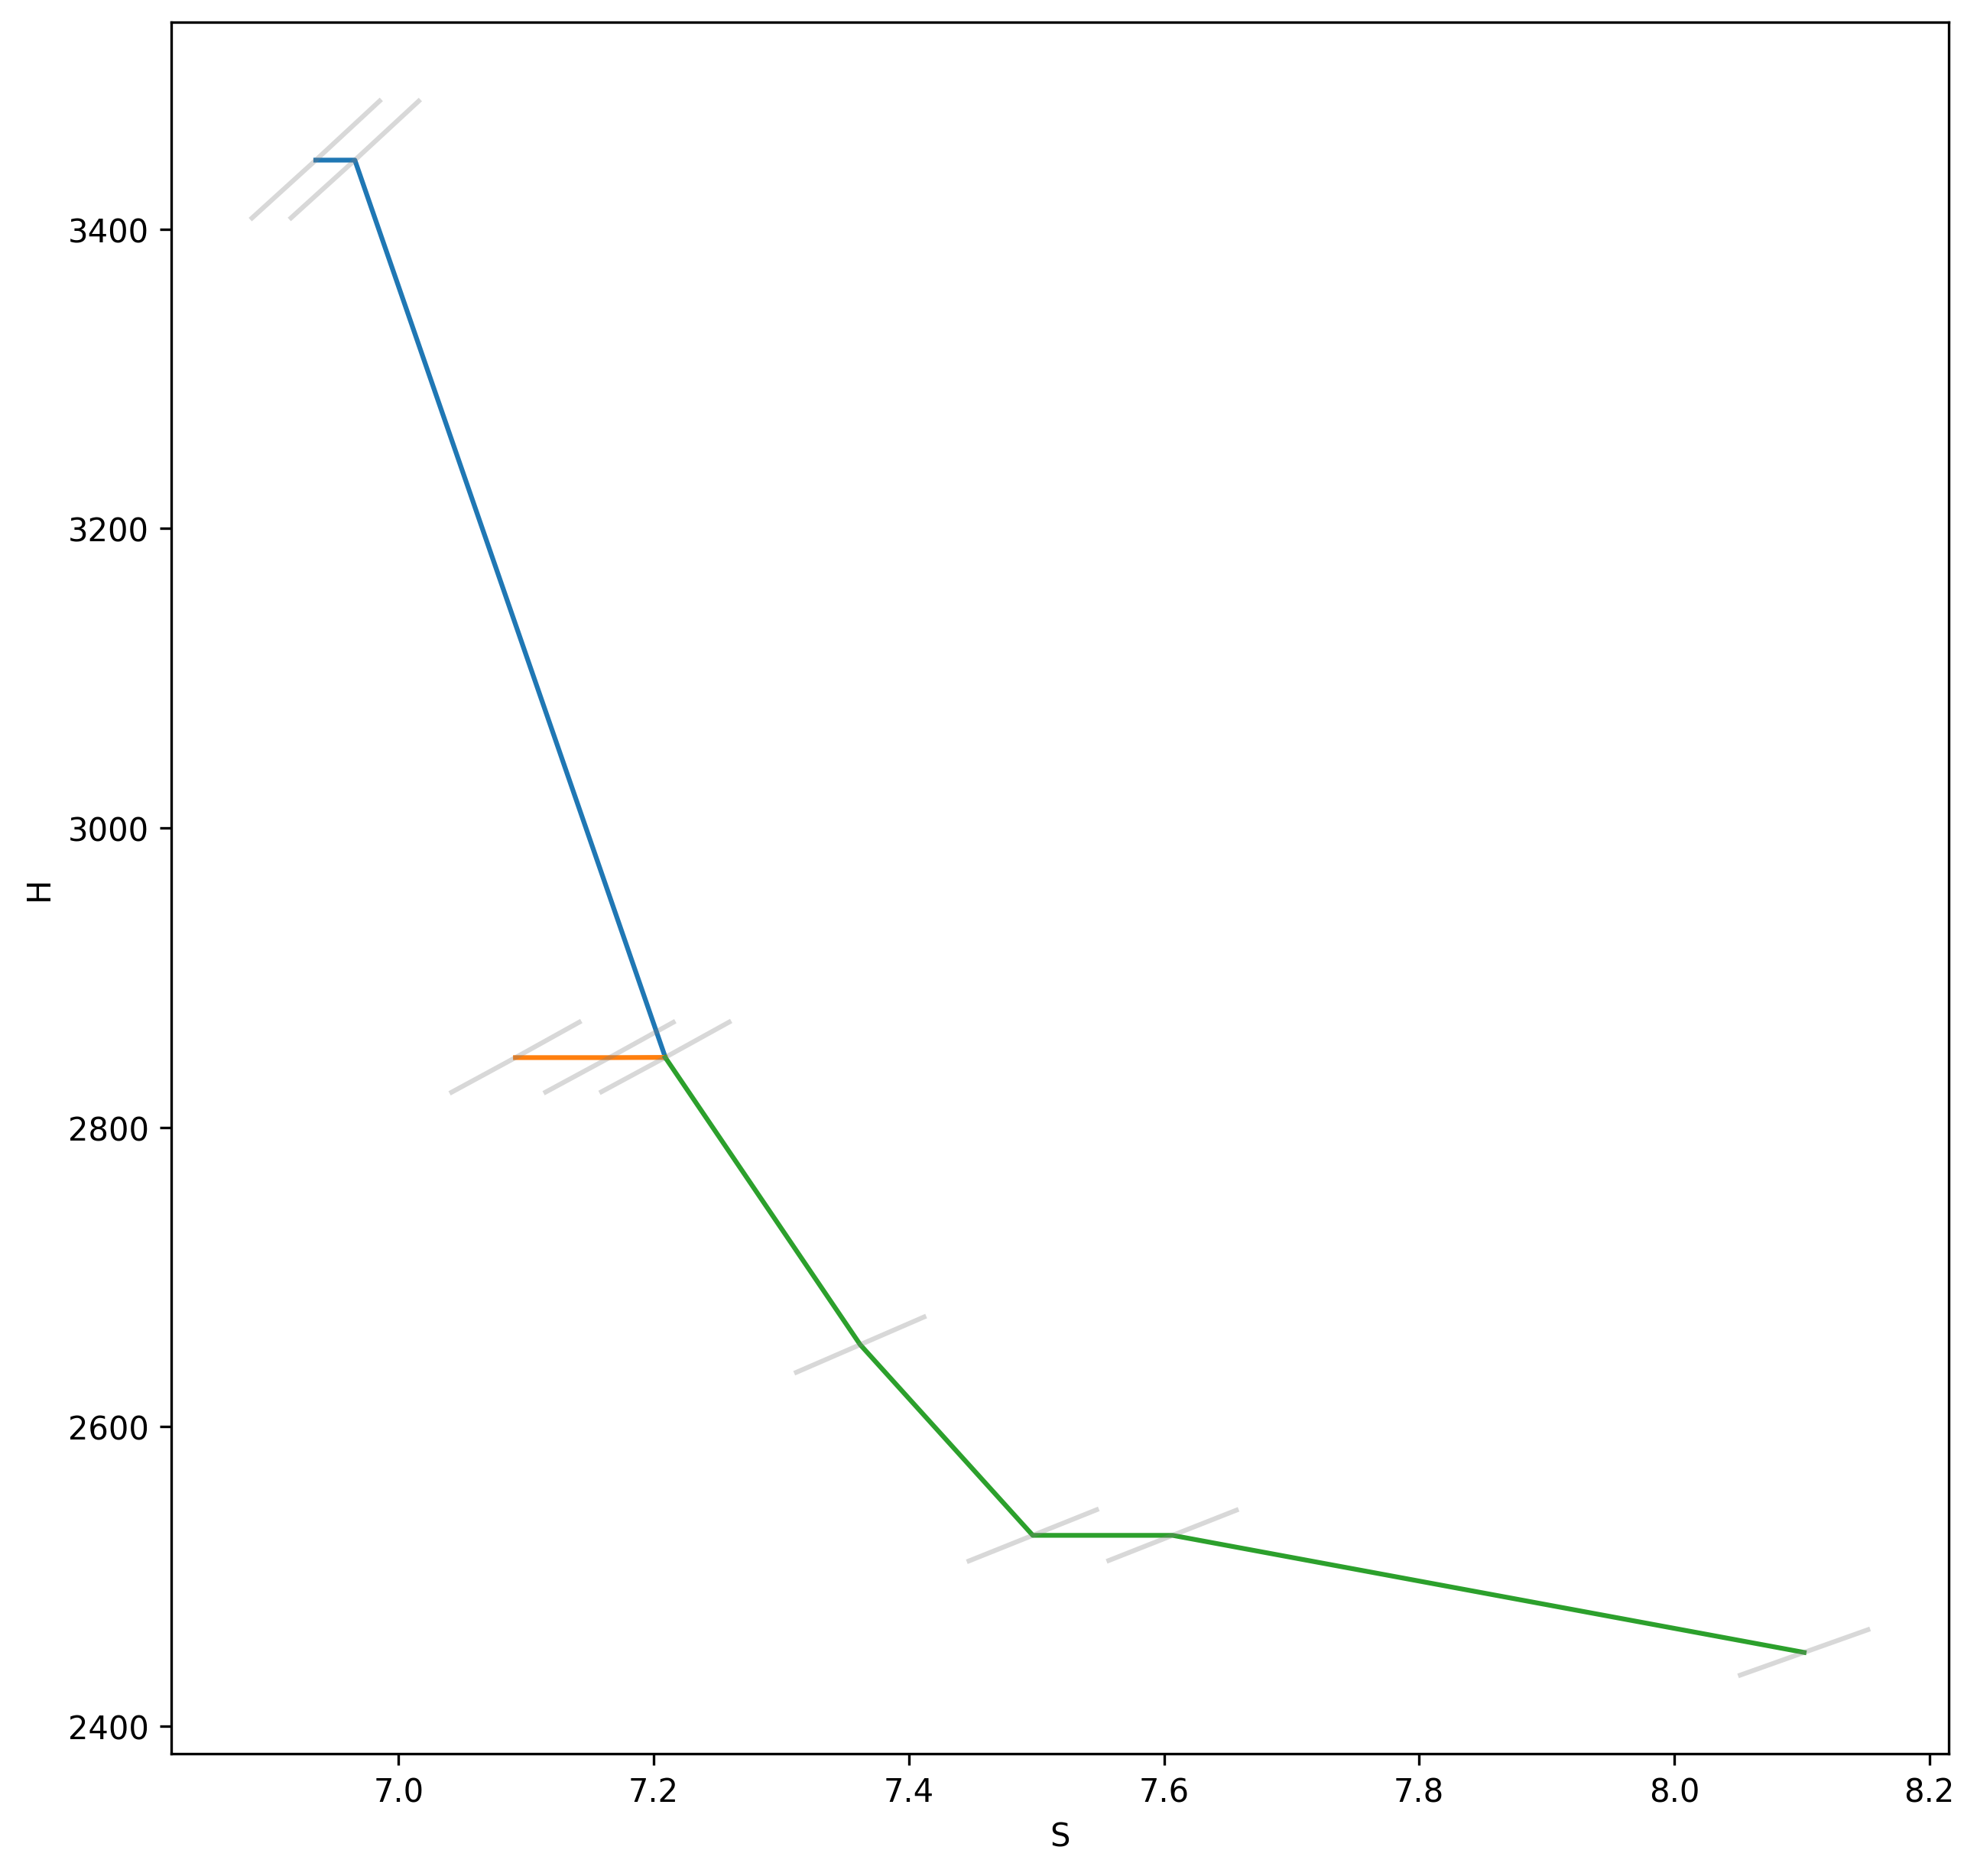

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,508.231766,5.696025,3446.079588,42.594724,6.935087,NaN
IVD-PEVD,274.853899,5.933062,2785.311621,42.594724,NaN,NaN
EVD-IVD,274.853899,5.933062,1228.658001,42.594724,NaN,NaN
PEN-EVD,175.984297,5.933062,747.991615,42.594724,NaN,NaN
BND-PEN,148.050076,0.451792,623.770811,42.594724,NaN,NaN
PPND-DROSND,194.394145,0.447224,2846.633065,11.053007,7.091595,NaN
IND-PPND,148.050076,0.451792,2743.564580,11.053007,NaN,NaN
GPK-IND,145.151795,0.451792,611.313113,53.647731,NaN,NaN
GPK-REC,145.151795,0.451792,611.313113,65.757493,NaN,NaN


In [9]:
import Grafiki

Q_t_graf=Grafiki.Q_t_diagram(gas_streams, water_streams, heaters, 15, 10)
H_s_graf=Grafiki.H_S_diagram(water, water_streams, 10, 10)
water_streams